In [1]:
import random
import math
import numpy as np


Generated 400 samples.


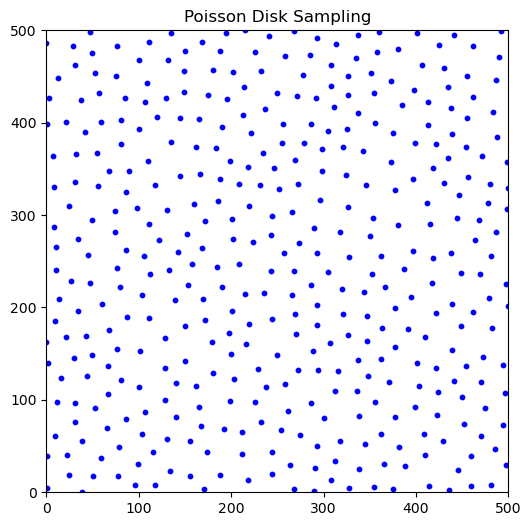

In [7]:

def poisson_disk_sampling(width, height, r, k=30):
    """
    Generate Poisson disk samples in a 2D region [0, width] x [0, height].

    Parameters:
        width (float): Width of the domain.
        height (float): Height of the domain.
        r (float): Minimum allowed distance between points.
        k (int): Maximum number of candidates to try for each active point (default 30).

    Returns:
        samples (list of tuple): A list of generated sample points.
    """
    # Step 1: Prepare grid data structure.
    # Each grid cell has side length equal to r / sqrt(2) so that each cell can contain at most one point.
    cell_size = r / math.sqrt(2)
    grid_width = int(math.ceil(width / cell_size))
    grid_height = int(math.ceil(height / cell_size))
    grid = [[None for _ in range(grid_height)] for _ in range(grid_width)]
    
    # Lists for samples and active points.
    samples = []
    active_list = []

    def get_grid_coords(point):
        """Convert a point's coordinates to its grid indices."""
        return int(point[0] // cell_size), int(point[1] // cell_size)
    
    # Step 2: Initialize with one random point.
    initial_point = (random.uniform(0, width), random.uniform(0, height))
    samples.append(initial_point)
    active_list.append(initial_point)
    gx, gy = get_grid_coords(initial_point)
    grid[gx][gy] = initial_point

    # Step 3: Process active points.
    while active_list:
        # Randomly choose an active point.
        idx = random.randint(0, len(active_list) - 1)
        point = active_list[idx]
        found_candidate = False

        for _ in range(k):
            # Generate a candidate in the annulus between r and 2r.
            angle = random.uniform(0, 2 * math.pi)
            rad = random.uniform(r, 2 * r)
            candidate = (point[0] + rad * math.cos(angle), point[1] + rad * math.sin(angle))

            # Check if candidate lies within the domain.
            if not (0 <= candidate[0] < width and 0 <= candidate[1] < height):
                continue

            # Get grid cell coordinates for the candidate.
            cx, cy = get_grid_coords(candidate)
            valid = True

            # Check neighboring cells (covering a 5x5 window) for points too close.
            for i in range(max(cx - 2, 0), min(cx + 3, grid_width)):
                for j in range(max(cy - 2, 0), min(cy + 3, grid_height)):
                    neighbor = grid[i][j]
                    if neighbor is not None:
                        dx = neighbor[0] - candidate[0]
                        dy = neighbor[1] - candidate[1]
                        if dx * dx + dy * dy < r * r:
                            valid = False
                            break
                if not valid:
                    break

            if valid:
                # Candidate is good: add it to samples, active list, and update the grid.
                samples.append(candidate)
                active_list.append(candidate)
                grid[cx][cy] = candidate
                found_candidate = True
                break  # Stop after a successful candidate.

        if not found_candidate:
            # No valid candidate found: remove the point from the active list.
            active_list.pop(idx)
    
    return samples

# Example usage:
if __name__ == "__main__":
    # Domain size and minimum distance
    width, height = 500, 500
    r = 20

    samples = poisson_disk_sampling(width, height, r)
    print("Generated", len(samples), "samples.")

    # Optional: Visualize the points using matplotlib
    try:
        import matplotlib.pyplot as plt
        xs, ys = zip(*samples)
        plt.figure(figsize=(6, 6))
        plt.scatter(xs, ys, c='blue', s=10)
        plt.xlim(0, width)
        plt.ylim(0, height)
        plt.title("Poisson Disk Sampling")
        plt.gca().set_aspect('equal')
        plt.show()
    except ImportError:
        print("Install matplotlib to visualize the samples.")


Generated 702 samples.


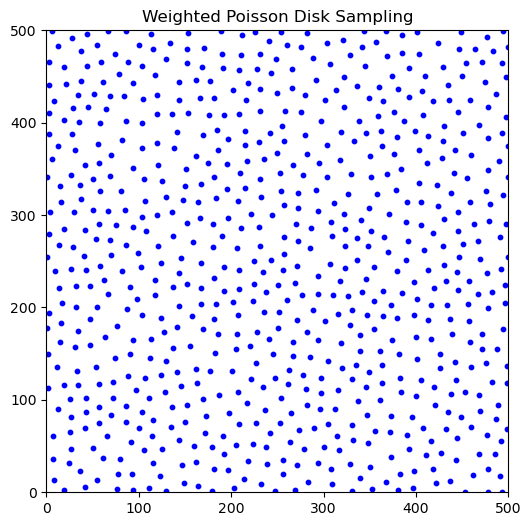

In [11]:
import random
import math

# We'll use numpy for building the cumulative density for the candidate radius.
import numpy as np

def sample_radius(r_min, r_max, g, num_samples=1000):
    """
    Sample a radial distance r in [r_min, r_max] according to the PDF:
       P(r) ~ g(r) * r
    (the extra r comes from the polar Jacobian in 2D).
    """
    r_values = np.linspace(r_min, r_max, num_samples)
    pdf = np.array([g(r)*r for r in r_values])
    # Normalize the PDF into a CDF
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    u = random.random()
    idx = np.searchsorted(cdf, u)
    return float(r_values[min(idx, num_samples - 1)])


def weighted_poisson_disk_sampling(width, height, r_min, g,
                                   k=30, r_max_factor=2.0):
    """
    Generate 2D samples in [0,width] x [0,height] with a pair
    distribution shaped by g(r). The candidate generation step samples
    a distance from P(r) ~ g(r)*r (i.e. biased by g), and the rejection test
    accepts a candidate with probability based on how its distance to nearby
    points compares to its own sampled radius.
    
    Parameters:
      width, height: Domain dimensions.
      r_min: Hard minimum distance (points closer than r_min are rejected).
      g: A callable function g(r) > 0 that describes the target pair correlation.
         (Higher values mean that separation is more desired.)
      k: Maximum candidate attempts per active point.
      r_max_factor: Factor to multiply r_min to set the maximum candidate distance.
    
    Returns:
      samples: A list of (x,y) sample points.
    """
    
    # Set the maximum candidate radius.
    r_max = r_min * r_max_factor
    
    # Cell size is based on the hard minimum to ensure at most one point per cell.
    cell_size = r_min / math.sqrt(2)
    grid_width = int(math.ceil(width / cell_size))
    grid_height = int(math.ceil(height / cell_size))
    # Each cell will either be None or store one point.
    grid = [[None for _ in range(grid_height)] for _ in range(grid_width)]
    
    samples = []
    active_list = []
    
    def get_grid_coords(pt):
        return int(pt[0] // cell_size), int(pt[1] // cell_size)
    
    # Start with one random point.
    initial_point = (random.uniform(0, width), random.uniform(0, height))
    samples.append(initial_point)
    active_list.append(initial_point)
    gx, gy = get_grid_coords(initial_point)
    grid[gx][gy] = initial_point
    
    # Main loop.
    while active_list:
        idx = random.randint(0, len(active_list) - 1)
        point = active_list[idx]
        found_candidate = False
        
        for _ in range(k):
            # --- Candidate Generation Step ---
            # Sample a candidate radial distance using the weighted PDF.
            r_candidate = sample_radius(r_min, r_max, g)
            # Choose angle uniformly.
            angle = random.uniform(0, 2 * math.pi)
            candidate = (point[0] + r_candidate * math.cos(angle),
                         point[1] + r_candidate * math.sin(angle))
            
            # Check if candidate is within domain.
            if not (0 <= candidate[0] < width and 0 <= candidate[1] < height):
                continue
            
            # --- Rejection Test ---
            # Get grid cell for candidate.
            cx, cy = get_grid_coords(candidate)
            accept_prob = 1.0  # start with full acceptance
            
            # Check the neighboring cells.
            conflict = False
            for i in range(max(cx - 2, 0), min(cx + 3, grid_width)):
                for j in range(max(cy - 2, 0), min(cy + 3, grid_height)):
                    neighbor = grid[i][j]
                    if neighbor is None:
                        continue
                    # Compute Euclidean distance.
                    dx = candidate[0] - neighbor[0]
                    dy = candidate[1] - neighbor[1]
                    d = math.hypot(dx, dy)
                    
                    # Hard rejection: if any neighbor is too close.
                    if d < r_min:
                        conflict = True
                        break
                    # Otherwise, compute the ratio.
                    # Here, we want the candidate's distance to the neighbor (d)
                    # to be consistent with its sampled r_candidate.
                    # If g(d) is lower than g(r_candidate), then this candidate is less ideal.
                    ratio = g(d) #/ g(r_candidate)
                    # We combine the ratios conservatively by taking the minimum.
                    accept_prob = min(accept_prob, ratio)
                if conflict:
                    break
            
            if conflict:
                continue  # Reject candidate immediately.
            
            # Finally, decide probabilistically.
            if random.random() < accept_prob:
                # Accept candidate.
                samples.append(candidate)
                active_list.append(candidate)
                gx, gy = get_grid_coords(candidate)
                grid[gx][gy] = candidate
                found_candidate = True
                break  # Stop trying further candidates for this active point.
        
        if not found_candidate:
            # If no candidate was accepted, remove this active point.
            active_list.pop(idx)
    
    return samples

# ==============================
# Example Usage
# ==============================
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Example target pair distribution function.
    # For illustration, let’s say we want to favor separations near r0,
    # so we make g(r) a Gaussian centered at r0.
    r0 = 30.0
    sigma = 5.0
    def g(r):
        # Avoid division by zero and ensure positivity.
        Γ, κ = 100,2
        return np.exp(-Γ/r*np.exp(-κ*r))

    width, height = 500, 500
    r_min = 15  # Hard minimum distance
    samples = weighted_poisson_disk_sampling(width, height, r_min, g, k=30, r_max_factor=2.0)
    print("Generated", len(samples), "samples.")

    xs, ys = zip(*samples)
    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, c='blue', s=10)
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.title("Weighted Poisson Disk Sampling")
    plt.gca().set_aspect('equal')
    plt.show()


Generated 2097 samples.


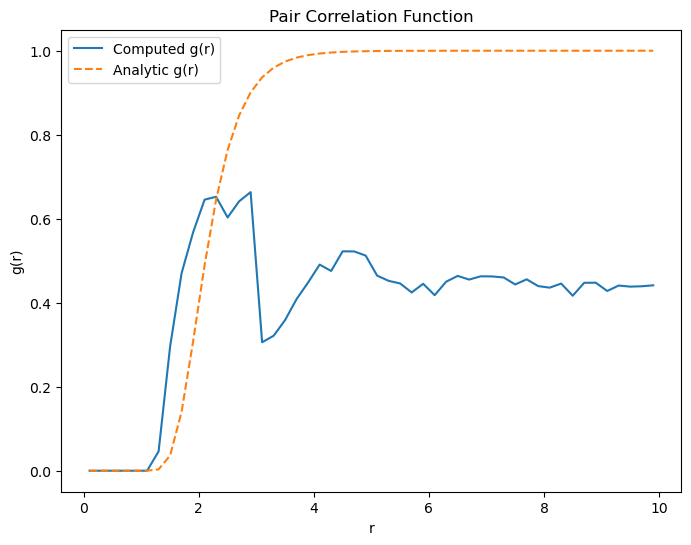

In [23]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# ========================================================
# Weighted Poisson Disk Sampling with a target g(r)
# ========================================================

def sample_radius(r_min, r_max, g, num_samples=1000):
    """
    Sample a radial distance r in [r_min, r_max] with probability density:
       P(r) ~ g(r) * r
    (The extra r factor is the Jacobian for polar coordinates in 2D.)
    """
    r_values = np.linspace(r_min, r_max, num_samples)
    pdf = np.array([g(r) * r for r in r_values])
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    u = random.random()
    idx = np.searchsorted(cdf, u)
    return float(r_values[min(idx, num_samples - 1)])


def weighted_poisson_disk_sampling(width, height, r_min, g, k=30, r_max_factor=2.0):
    """
    Generate 2D samples in [0,width] x [0,height] with a pair distribution
    shaped by the target function g(r).

    For each active point, a candidate is generated by sampling a radial
    distance from P(r) ~ g(r)*r (i.e. biased by g) over the annulus
    [r_min, r_max=r_min*r_max_factor] and picking an angle uniformly.
    
    Then, for each candidate the distance to nearby points is checked.
    For each neighbor at distance d, we compute:
        ratio = g(d) / g(r_candidate)
    and use the minimum ratio over all neighbors as an acceptance probability.
    
    A candidate is rejected immediately if any neighbor is closer than r_min.

    Parameters:
      width, height: Domain dimensions.
      r_min: Hard minimum distance.
      g: A callable g(r) > 0, the target pair correlation function.
      k: Maximum candidate attempts per active point.
      r_max_factor: Multiplier for r_min to set maximum candidate distance.
    
    Returns:
      samples: A list of (x, y) tuples.
    """
    r_max = r_min * r_max_factor
    cell_size = r_min / math.sqrt(2)
    grid_width = int(math.ceil(width / cell_size))
    grid_height = int(math.ceil(height / cell_size))
    grid = [[None for _ in range(grid_height)] for _ in range(grid_width)]
    
    samples = []
    active_list = []
    
    def get_grid_coords(pt):
        return int(pt[0] // cell_size), int(pt[1] // cell_size)
    
    # Start with a random point.
    initial_point = (random.uniform(0, width), random.uniform(0, height))
    samples.append(initial_point)
    active_list.append(initial_point)
    gx, gy = get_grid_coords(initial_point)
    grid[gx][gy] = initial_point
    
    while active_list:
        idx = random.randint(0, len(active_list) - 1)
        point = active_list[idx]
        found_candidate = False
        
        for _ in range(k):
            # -- Candidate Generation --
            r_candidate = sample_radius(r_min, r_max, g)
            angle = random.uniform(0, 2 * math.pi)
            candidate = (point[0] + r_candidate * math.cos(angle),
                         point[1] + r_candidate * math.sin(angle))
            
            # Candidate must lie within the domain.
            if not (0 <= candidate[0] < width and 0 <= candidate[1] < height):
                continue
            
            cx = int(candidate[0] // cell_size)
            cy = int(candidate[1] // cell_size)
            accept_prob = 1.0
            conflict = False
            
            # Check nearby grid cells (a 5x5 block around candidate).
            for i in range(max(cx - 2, 0), min(cx + 3, grid_width)):
                for j in range(max(cy - 2, 0), min(cy + 3, grid_height)):
                    neighbor = grid[i][j]
                    if neighbor is None:
                        continue
                    dx = candidate[0] - neighbor[0]
                    dy = candidate[1] - neighbor[1]
                    d = math.hypot(dx, dy)
                    
                    if d < r_min:
                        conflict = True
                        break
                    ratio = g(d)# / g(r_candidate)
                    accept_prob = min(accept_prob, ratio)
                if conflict:
                    break
            
            if conflict:
                continue  # Reject candidate immediately.
            
            # Accept candidate probabilistically.
            if random.random() < accept_prob:
                samples.append(candidate)
                active_list.append(candidate)
                gx, gy = get_grid_coords(candidate)
                grid[gx][gy] = candidate
                found_candidate = True
                break  # Candidate accepted; move on.
        
        if not found_candidate:
            active_list.pop(idx)
    
    return samples

# ========================================================
# Pair Correlation Function (g(r)) Computation via Histogram
# ========================================================

def compute_pair_correlation(samples, width, height, rmax, nbins):
    """
    Compute the pair correlation function g(r) (also known as the radial
    distribution function) using histogram binning and a spatial subgrid to
    efficiently search for nearby pairs.

    Parameters:
      samples: List of (x,y) points.
      width, height: Domain dimensions.
      rmax: Maximum distance up to which g(r) is computed.
      nbins: Number of bins in the histogram.
    
    Returns:
      r_vals: List of bin center radii.
      g_vals: Computed g(r) values for each bin.
    """
    N = len(samples)
    area = width * height
    density = N / area
    dr = rmax / nbins
    hist = [0] * nbins

    # Build a subgrid for efficient neighbor search.
    # We'll choose a cell size of rmax/2 so that the number of cells is moderate.
    cell_size = rmax / 2
    grid_width = int(math.ceil(width / cell_size))
    grid_height = int(math.ceil(height / cell_size))
    grid = [[[] for _ in range(grid_height)] for _ in range(grid_width)]
    
    # Insert points (with their indices) into the grid.
    for idx, (x, y) in enumerate(samples):
        gx = int(x // cell_size)
        gy = int(y // cell_size)
        grid[gx][gy].append(idx)
    
    # For each point, check neighbors only in nearby cells.
    for i, (x, y) in enumerate(samples):
        gx = int(x // cell_size)
        gy = int(y // cell_size)
        delta = int(math.ceil(rmax / cell_size))
        for ix in range(max(gx - delta, 0), min(gx + delta + 1, grid_width)):
            for iy in range(max(gy - delta, 0), min(gy + delta + 1, grid_height)):
                for j in grid[ix][iy]:
                    if j <= i:  # Count each pair only once.
                        continue
                    x2, y2 = samples[j]
                    d = math.hypot(x2 - x, y2 - y)
                    if d < rmax:
                        bin_index = int(d // dr)
                        if bin_index < nbins:
                            hist[bin_index] += 1

    # Normalize the histogram to obtain g(r).
    # For 2D, the expected number of neighbors in an annulus of radius r and width dr is:
    #   expected = density * (area of annulus) = density * (π[(r+dr)^2 - r^2])
    r_vals = []
    g_vals = []
    for i in range(nbins):
        r_inner = i * dr
        r_center = r_inner + dr / 2
        annulus_area = math.pi * ((r_inner + dr)**2 - r_inner**2)
        expected = N * density * annulus_area  # Expected count over all points.
        # Avoid division by zero.
        g_val = hist[i] / expected if expected > 0 else 0
        r_vals.append(r_center)
        g_vals.append(g_val)
    
    return r_vals, g_vals

# ========================================================
# Example Usage and Plotting
# ========================================================

if __name__ == "__main__":
    # Domain parameters.
    width, height = 100, 100

    def g_target(r):
        Γ, κ = 100,2
        return np.exp(-Γ/r*np.exp(-κ*r))

    # Sampling parameters.
    r_min = 1  # Hard minimum distance.
    samples = weighted_poisson_disk_sampling(width, height, r_min, g_target, k=30, r_max_factor=3.0)
    print("Generated", len(samples), "samples.")
    
    # Compute the pair correlation function from the samples.
    rmax = 10  # Maximum distance for g(r) calculation.
    nbins = 50  # Number of histogram bins.
    r_vals, computed_g = compute_pair_correlation(samples, width, height, rmax, nbins)
    
    # Compute analytic g(r) values at the bin centers.
    analytic_g = [g_target(r) for r in r_vals]
    
    # Plot the computed and analytic pair correlation functions.
    plt.figure(figsize=(8, 6))
    plt.plot(r_vals, computed_g, label='Computed g(r)')
    plt.plot(r_vals, analytic_g, label='Analytic g(r)', linestyle='--')
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.title('Pair Correlation Function')
    plt.legend()
    plt.show()


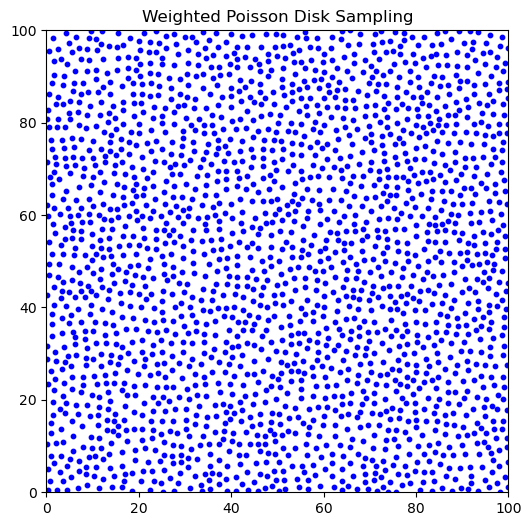

In [27]:
xs, ys = zip(*samples)

plt.figure(figsize=(6, 6))
plt.scatter(xs, ys, c='blue', s=10)
plt.xlim(0, width)
plt.ylim(0, height)
plt.title("Weighted Poisson Disk Sampling")
plt.gca().set_aspect('equal')
plt.show()